In [1]:
%matplotlib inline
import os 
import numpy as np
from numpy import mean, std
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_rel, ttest_ind, mannwhitneyu, wilcoxon, spearmanr,pearsonr, fisher_exact,kstest
from scipy.stats import ks_2samp, kstest, anderson, anderson_ksamp, levene
from statsmodels.sandbox.stats.multicomp import fdrcorrection0
from sklearn import preprocessing
import statsmodels.api as sm
pd.options.display.max_columns = 999
import statsmodels.formula.api as smf
import scipy.stats as ss 
from sklearn.decomposition import TruncatedSVD, PCA
import math 
from outliers import smirnov_grubbs as grubbs
sns.set_style('white')
import math 
workspace_dir  = '/Users/kanaan/Google Drive/TS-EUROTRAIN/RESULTS_QSMv3/SEPT10'
#workspace_dir  = '/scr/malta3/workspace/project_iron/phenotypic'
pheno_dir      = os.path.join(workspace_dir, 'phenotypic')
clinical_dir   = os.path.join(workspace_dir, 'DF_clinical')
save_fig_dir   = '/Users/kanaan/Google Drive/TS-EUROTRAIN/Papers/2016_QSM_paper/Figures_python_v2'

dpi = 300
pca_mult = 10
cmap_b = ["#1300ff", "#87d6e9"]

/Users/kanaan/anaconda/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
patients = pd.read_csv(os.path.join(pheno_dir, 'df_patients_qc_PCA.csv'),index_col = 1)
loadings = pd.read_csv(os.path.join(pheno_dir, 'pca_loadings.csv'),index_col = 0)
scores   = pd.read_csv(os.path.join(pheno_dir, 'pca_scores.csv'),index_col = 0)
cln   = pd.read_csv(os.path.join(pheno_dir, 'cln.csv'),index_col = 0)


In [3]:
loadings

,PC1,PC2,PC3,PC4
CLN_YGTSS_Motoric_Score,0.086454,0.763656,0.037303,0.134794
CLN_YGTSS_Vocal_Score,0.449917,0.734004,-0.111576,-0.205468
CLN_RVTRS,-0.106479,0.792375,-0.053626,0.192087
CLN_puts,0.540091,-0.043358,-0.258591,0.647714
CLN_OCIR_total_score,0.108478,0.304342,0.265577,0.779102
CLN_DSM4_ADHD_Score,0.133158,-0.035739,0.868917,-0.052139
CLN_CAARS_Score_ADHS_Symptoms_Total_Cat_G_T_Score,0.343167,-0.063475,0.753976,0.397194
CLN_BAI,0.867210,-0.028379,0.244101,0.023962
CLN_BDI12,0.766431,0.101769,0.230543,0.480853
CLN_MADRS,0.767217,0.216333,0.157935,0.170644


In [4]:
def detect_outlier_subjects(df,measure,m=2):
    upper = np.mean(df[measure]) + m * np.std(df[measure])
    lower = np.mean(df[measure]) - m * np.std(df[measure])

    for subject in df.index:
        if df.loc[subject][measure] > upper:
            print subject
        elif df.loc[subject][measure] < lower:
            print subject

def grubbs_outliers(df, measure, alpha = 0.15):
    from outliers import smirnov_grubbs as grubbs
    return [str(i) for i in df.index if i not in grubbs.test(df[measure], alpha).index] 

def reject_outliers(data, m=3):
    return data[abs(data - np.mean(data)) < m * np.std(data)]


def gESD_outliers(df, measure, maxOLs =10, alpha = 0.05):
    from PyAstronomy import pyasl
    index = pyasl.generalizedESD(df[measure],maxOLs = maxOLs, alpha =alpha, fullOutput=True)[1]
    return [df.index[i] for i in index] 

def gESD_outliersx(df, maxOLs =10, alpha = 0.05):
    from PyAstronomy import pyasl
    index = pyasl.generalizedESD(df,maxOLs = maxOLs, alpha =alpha, fullOutput=True)[1]
    return [df.index[i] for i in index] 

def sortdf(df,m):
    return df.sort(m)[m]
 
def plot_partial_correlation(data, x, y,xlim = None, ylim = None, regressors = None, color = None, annotate = 0, fig_name = None, 
                             dpi = 100, labels = True, jitter = None,fit_reg=True, scatter=1,
                             plot_marg = 1, ci = 95, lstyle='-',lw=2.5,
                            y_axis_flip=0):
    
    regressors_columns = [data[regressor] for regressor in regressors]
    df_reg = pd.concat(regressors_columns, axis = 1).dropna(axis=0) 
    df = pd.concat([df_reg, data[x], data[y]], axis=1).dropna()
    
    # inititlize grid and plot regression and margins 
    grid = sns.JointGrid(x, y, data=df,xlim=xlim, ylim=ylim)#, size=size, ratio=ratio, space=space, #) 
    
    if plot_marg:
        grid.plot_marginals(sns.distplot, color = color, hist=False, kde = True, rug = 0, kde_kws={'shade':True})  
    
    grid.plot_joint(sns.regplot, fit_reg=fit_reg, scatter= scatter, color = color, x_partial = df[regressors], y_jitter = jitter, 
                    ci = ci, line_kws={'linestyle': lstyle, 'lw':lw}, scatter_kws={"s": 25})
    if labels:
        grid.set_axis_labels()
        #grid.set_axis_labels(x, y, fontsize= 15, weight='bold', color='blue', labelpad=10)
    else:
        grid.set_axis_labels()
    
    ## calculate regression parameters 
    
    formula = [ '%s ~ %s'%(y,x) + ' + %s'%regressor for regressor in regressors][0]
    model   = smf.ols(formula=formula, data= df)
    result = model.fit() 
    p_val  = np.round(result.pvalues[1], 7)
    pcor   = math.copysign(np.round(np.sqrt(result.rsquared), 3) , result.params[1])
    plt.ylabel(y)
    plt.xlabel(x)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    
    if annotate == 1:
        annotate = (plt.xlim()[1]*0.6,  plt.ylim()[1]*0.95)
        plt.annotate('R=%s, P=%s' %(pcor, p_val), xy = annotate, fontsize = 13,  color='r')
    elif annotate == 0:
        pass
    else:
        plt.annotate('R=%s, P=%s' %(pcor, p_val), xy = annotate, fontsize = 13,  color='r')
    
    grid.set_axis_labels()
    plt.xticks(fontsize=12, weight='bold')
    plt.yticks(fontsize=12, weight='bold')
    
    
    if y_axis_flip:
        plt.setp(grid.ax_joint.get_yticklabels(), visible=0)
        #plt.setp(grid.ax_joint.set_ticks_position,'right')
        #ax.yaxis.tick_right()
        #ax.yaxis.set_label_position("right")
        
    if fig_name:
        plt.savefig(os.path.join(save_fig_dir, fig_name), dpi = dpi, bbox_inches='tight', transparent = True)

    
    
    print pcor, p_val
    return result


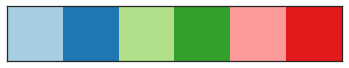

In [5]:
#sns.palplot(sns.color_palette("hls", 8))
sns.palplot(sns.color_palette("Paired"))
blue = sns.color_palette("Paired")[1]
green = sns.color_palette("Paired")[3]
red = sns.color_palette("Paired")[5]
redx = sns.color_palette("Paired")[4]

# Correlation Matrix

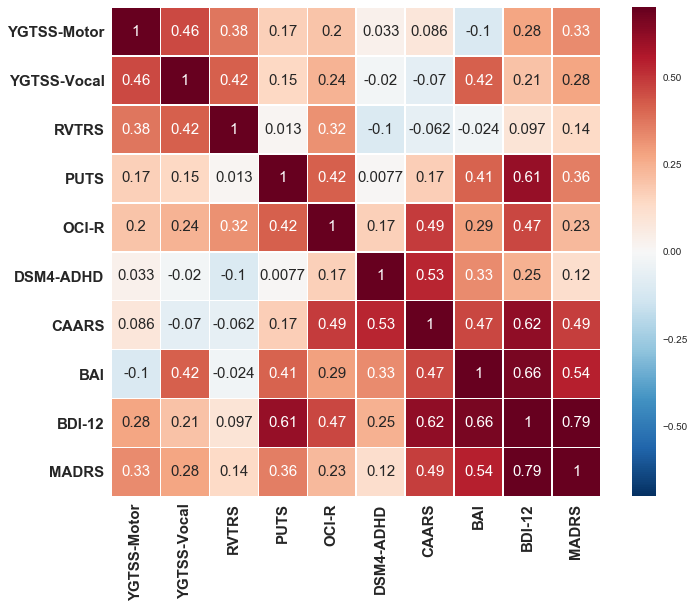

In [6]:
df = patients.drop([], axis = 0 )
cln_metrics = [df['CLN_YGTSS_Motoric_Score'],
               df['CLN_YGTSS_Vocal_Score'], 
               df['CLN_RVTRS'],
               df['CLN_puts'],
               #df['CLN_qol_score'],
               df['CLN_OCIR_total_score'],
               df['CLN_DSM4_ADHD_Score'], 
               df['CLN_CAARS_Score_ADHS_Symptoms_Total_Cat_G_T_Score'], 
               #df['CLN_YBOCS_Totalscore_Items_1to10'],  
               df['CLN_BAI'],  
               df['CLN_BDI12'],  
               df['CLN_MADRS'],
              ]

df = pd.concat(cln_metrics,  axis=1)
corr = df.corr('pearson')
mask = np.zeros_like(corr, dtype=np.bool)
#mask[np.triu_indices_from(mask, k = 1)] = True
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
cmap = 'seismic'
cmap = 'RdBu_r'
sns.heatmap(corr, cmap = cmap ,
            mask=mask,square=True, vmin = -.7, vmax = .7,
            linewidths=.5, cbar_kws={"shrink": 1}, ax=ax, 
            annot = True, 
            annot_kws={"size":15})
ticks  =  [x + .5 for x in range(0,10)]
labelx = ['YGTSS-Motor', 'YGTSS-Vocal', 'RVTRS', 'PUTS', #'CAARS','Y-BOCS', 
          'OCI-R', 'DSM4-ADHD','CAARS', 'BAI', 'BDI-12','MADRS']
plt.xticks(ticks, labelx, fontsize = 15, weight='bold')
plt.yticks(ticks[::-1], labelx, fontsize = 15, weight='bold')

plt.savefig(os.path.join(save_fig_dir, 'cln_corr.png'), dpi = 300, bbox_inches='tight', transparent = True)
    


# MOTOR Prinicpal Component

In [7]:
df = patients
PC_val = 'PC2'
df[PC_val] = df[PC_val] * -1
detect_outlier_subjects(df,PC_val,m=2)


RMJP


-0.563 0.0203801


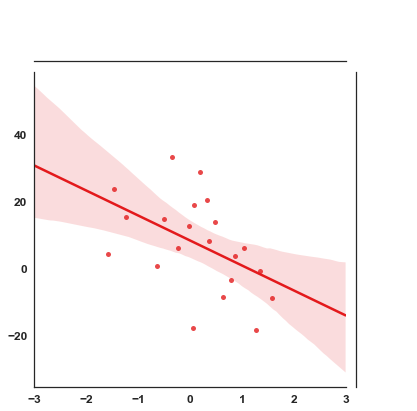

In [8]:
PC_val = 'PC2'
plot_partial_correlation(df.drop(['YU1P', 'HHQP'],axis=0), 
                         PC_val, 'Caud_Puta', 
                         xlim = (-3,3), 
                         ylim = None, regressors = ['Age','Gender', 'QC_PCA'], 
                         color = red, #annotate = (.23,0.3),
                         dpi = 500, labels = 0, jitter = 0.0001,fit_reg=True, scatter=1,
                         plot_marg = 0, ci = 95, lstyle='-',lw=2.5,
                         #fig_name = 'clinical_PCA_chi_tics.png'
                        )

In [9]:
detect_outlier_subjects(df,'PC2',m=2)
detect_outlier_subjects(df,'STR3_MOTOR',m=2)

RMJP
CF1P


-0.534 0.0735657


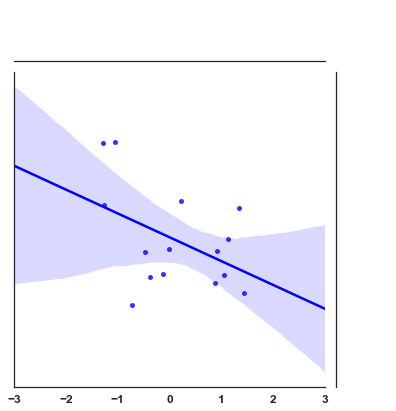

In [10]:
plot_partial_correlation(df.drop(['SA5U'],axis=0), 
                        'PC2', 'CLN_Ferritin', 
                         xlim = (-3,3), 
                         ylim = None, regressors = ['Age','Gender'], 
                         color = 'b', #annotate = (.23,0.3),
                         dpi = 500, labels = 0, jitter = 0.02,fit_reg=True, scatter=1,
                         plot_marg = 0, 
                         ci = 95, lstyle='-',lw=2.5,
                         fig_name = 'clinical_PCA_chi_ferritin.png',
                         y_axis_flip=1
                        )

-0.532 0.0746895


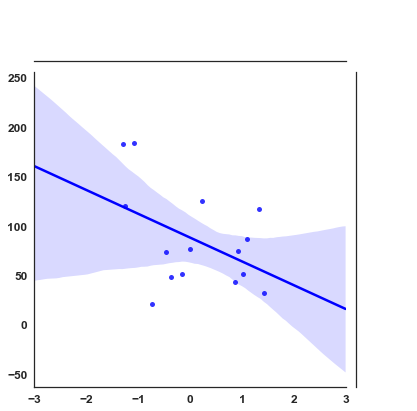

In [31]:
plot_partial_correlation(df.drop(['SA5U'],axis=0), 
                        'PC2', 'CLN_Ferritin', 
                         xlim = (-3,3), 
                         ylim = None, regressors = ['Age','Gender'], 
                         color = 'b', #annotate = (.23,0.3),
                         dpi = 500, labels = 0, jitter = 0.02,fit_reg=True, scatter=1,
                         plot_marg = 0, 
                         ci = 95, lstyle='-',lw=2.5,
                         fig_name = 'clinical_PCA_chi_ferritin_x.png',
                         y_axis_flip=0
                        )

In [32]:
loadings#.drop(['PC6', 'PC7','PC8','PC9'],axis=1).round(2)

,PC1,PC2,PC3,PC4
CLN_YGTSS_Motoric_Score,0.086454,0.763656,0.037303,0.134794
CLN_YGTSS_Vocal_Score,0.449917,0.734004,-0.111576,-0.205468
CLN_RVTRS,-0.106479,0.792375,-0.053626,0.192087
CLN_puts,0.540091,-0.043358,-0.258591,0.647714
CLN_OCIR_total_score,0.108478,0.304342,0.265577,0.779102
CLN_DSM4_ADHD_Score,0.133158,-0.035739,0.868917,-0.052139
CLN_CAARS_Score_ADHS_Symptoms_Total_Cat_G_T_Score,0.343167,-0.063475,0.753976,0.397194
CLN_BAI,0.867210,-0.028379,0.244101,0.023962
CLN_BDI12,0.766431,0.101769,0.230543,0.480853
CLN_MADRS,0.767217,0.216333,0.157935,0.170644


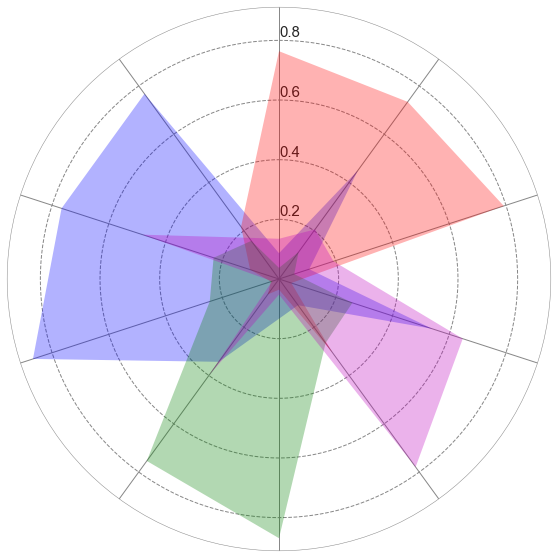

In [33]:
from math import pi
import matplotlib.pyplot as plt

# Set data
loadings = pd.read_csv(os.path.join(pheno_dir, 'pca_loadings.csv'),index_col = 0)

loading_index = [i for i in loadings.index]
cat = loading_index
values = list(loadings.PC1) # [90, 60, 65, 70, 40]
values2 = list(loadings.PC2) # [90, 60, 65, 70, 40]
values3 = list(loadings.PC3) # [90, 60, 65, 70, 40]
values4 = list(loadings.PC4) # [90, 60, 65, 70, 40]

N = len(cat)
x_as = [n / float(N) * 2 * pi for n in range(N)]

# Because our chart will be circular we need to append a copy of the first 
# value of each list at the end of each list with data
values.append(list(loadings.PC1)[0])
values = np.abs(np.array(values))

values2.append(list(loadings.PC2)[0])
values2 = np.abs(np.array(values2))

values3.append(list(loadings.PC3)[0])
values3 = np.abs(np.array(values3))

values4.append(list(loadings.PC4)[0])
values4 = np.abs(np.array(values4))

x_as += x_as[:1]

# Set color of axes
plt.rc('axes', linewidth=0.5, edgecolor="#888888")

# Create polar plot
fig = plt.figure(figsize=(20,20))
fig = plt.figure(figsize=(10,10))
ax = plt.subplot(111, polar=True)

# Set clockwise rotation. That is:
ax.set_theta_offset(pi / 2)
ax.set_theta_direction(-1)

#Set position of y-labels
ax.set_rlabel_position(0)

# Set color and linestyle of grid
ax.xaxis.grid(True, color="#888888", linestyle='solid', linewidth=1)
ax.yaxis.grid(True, color="#888888", linestyle='dashed', linewidth=1)##888888

# Set number of radial axes and remove labels
plt.xticks(x_as[:-1], loading_index, size = 25,weight='bold')
plt.xticks(x_as[:-1], [])

# Set yticks
#plt.yticks([20, 40, 60, 80, 100], ["20", "40", "60", "80", "100"])

ax.fill(x_as, values, 'b', alpha=0.3)
ax.fill(x_as, values2, 'r', alpha=0.3)
ax.fill(x_as, values3, 'g', alpha=0.3)
ax.fill(x_as, values4, 'm', alpha=0.3)

plt.tick_params(axis='y', direction='in', labelsize=15)
plt.tick_params(axis='x', direction='in', labelsize=15)

plt.savefig(os.path.join(save_fig_dir,'pca_loadings_polar.png'), dpi = dpi, bbox_inches='tight', transparent = True)

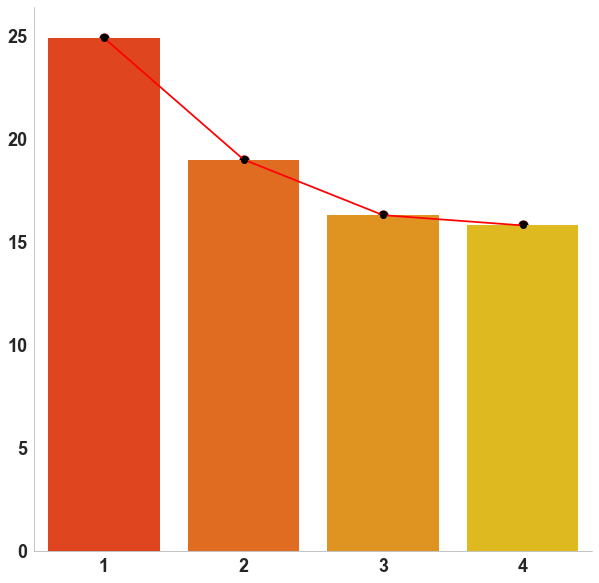

In [30]:
explained_var = np.asarray([0.249, 0.190, 0.163, 0.158]) * 100
explained_var_num = range(1,5)


fig, ax = plt.subplots(1)
fig.set_size_inches([10,10])

sns.barplot(explained_var_num, explained_var, palette='autumn')
plt.plot(np.array(explained_var_num) - 1, explained_var, marker="o", markerfacecolor="k", c= 'r')
plt.scatter(np.array(explained_var_num) - 1, explained_var, s=100, facecolors='k', edgecolors='r')
plt.yticks(fontsize=12, weight='bold')
plt.xticks(fontsize=12, weight='bold')
#plt.ylim(0,40)
#plt.xlim(-0.75,9)
plt.tick_params(axis='y', direction='in', labelsize=18)
plt.tick_params(axis='x', direction='in', labelsize=18)
sns.despine(left=False, bottom=False)


#plt.savefig(os.path.join(save_fig_dir, 'exp_var.png'), dppi  = 300, bbox_inches = 'tight')

In [38]:
x = cln.dropna().values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df = pd.DataFrame(x_scaled, columns=cln.columns)


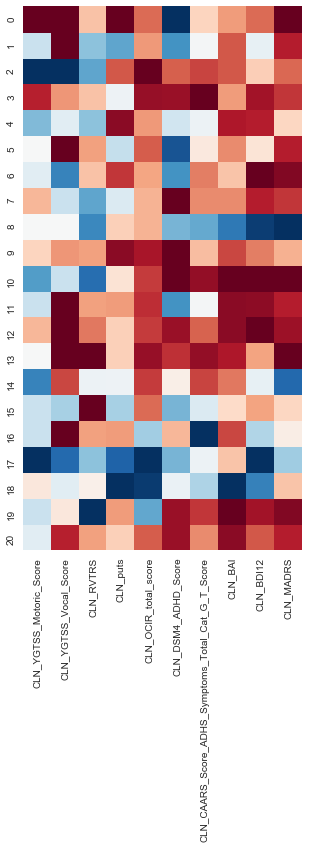

In [39]:
fig = plt.figure(figsize=(5, 10))
sns.heatmap(df, cmap = 'RdBu', cbar=False)

(None, <a list of 0 Text xticklabel objects>)

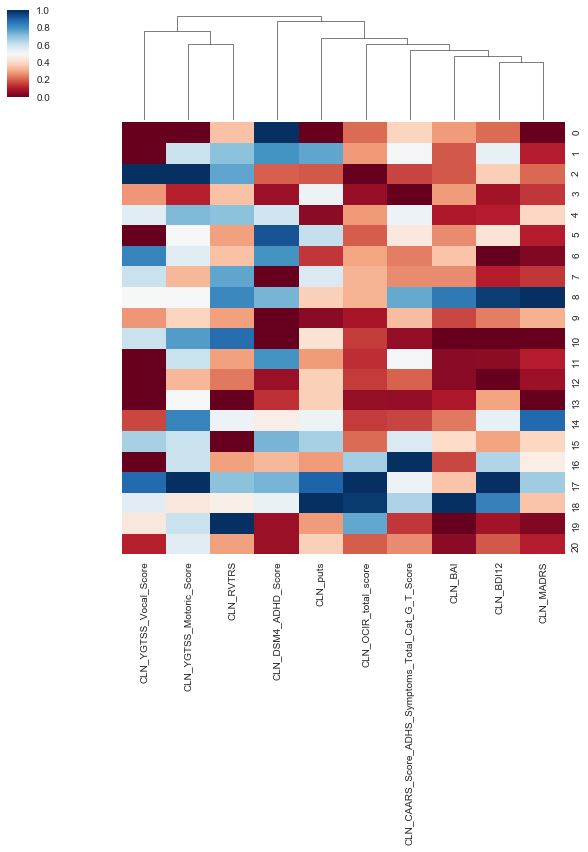

In [49]:
sns.clustermap(df, cmap = 'RdBu', cbar=1, row_cluster=0)



ticks  =  [x + .5 for x in range(0,10)]
plt.xticks(ticks, labelx, fontsize = 15, weight='bold')
#plt.yticks(ticks[::-1], labelx, fontsize = 15, weight='bold')